In [79]:
import pandas as pd
import numpy as np
from tqdm import tqdm,trange
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.power import  tt_ind_solve_power
from scipy.interpolate import interp1d

import statsmodels.stats.proportion as proportion
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import statsmodels.stats.power as smp

from IPython.display import clear_output
def test_ttest_power_diff(mean, std, sample1_size=None, alpha=0.05, desired_power=0.8, mean_diff_percentages=[0.1, 0.05], alternative='two-sided'):
    '''
    calculates the power function for a given mean and std. the function plots a graph showing the comparison between desired mean differences
    :param mean: the desired mean
    :param std: the std value
    :param sample1_size: if None, it is assumed that both samples (first and second) will have same size. The function then will
    walk through possible sample sizes (up to 100, hardcoded).
    If this value is not None, the function will check different alternatives for sample 2 sizes up to sample 1 size.
    :param alpha: alpha default value is 0.05
    :param desired_power: will use this value in order to mark on the graph
    :param mean_diff_percentages: iterable list of percentages. A line per value will be calculated and plotted.
    :return: None
    '''
    fig, ax = plt.subplots(figsize=(20,8))
    for mean_diff_percent in mean_diff_percentages:
        mean_diff = mean_diff_percent * mean
        effect_size = mean_diff / std

        print('Mean diff: ', mean_diff)
        print('Effect size: ', effect_size)

        powers = []

        max_size  = sample1_size
        if sample1_size is None:
            max_size = 100

        sizes = np.arange(1, max_size, 2)
        for sample2_size in tqdm(sizes):
            if(sample1_size is None):
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample2_size, alpha=alpha, ratio=1.0, alternative=alternative)
                #print('tt_ind_solve_power(alpha=', alpha, 'sample2_size=', sample2_size, '): sample size in *second* group: {:.5f}'.format(n))
            else:
                n = tt_ind_solve_power(effect_size=effect_size, nobs1=sample1_size, alpha=alpha, ratio=(1.0*sample2_size/sample1_size), alternative=alternative)
                #print('tt_ind_solve_power(alpha=', alpha, 'sample2_size=', sample2_size, '): sample size *each* group: {:.5f}'.format(n))

            powers.append(n)

        try: # mark the desired power on the graph
            z1 = interp1d(powers, sizes)
            results = z1(desired_power)

            clear_output()
            plt.plot([results], [desired_power], 'gD')
        except Exception as e:
            print("Error: ", e)
            #ignore

        plt.title('Power vs. Sample Size')
        plt.xlabel('Sample Size')
        plt.ylabel('Power')

        plt.plot(sizes, powers, label='diff={:2.0f}%'.format(100*mean_diff_percent))

    plt.grid()
    plt.legend()
    plt.show()

# данные

In [6]:
df_1 = pd.DataFrame({
    'report_dt': ['2022-01-31','2022-02-28','2022-03-31','2022-04-30','2022-05-31','2022-06-30','2022-07-31','2022-08-31','2022-09-30','2022-10-31','2022-11-30','2022-12-31'],
    'pnl': [24239.720640,32206.225298,75398.869019,31987.626818,30030.557276,42705.892979,41861.254020,32131.579967,33527.858703,32812.192752,31669.459546,31417.366505]
})
df_1 = df_1[['report_dt', 'pnl']]

df_1

,report_dt,pnl
0,2022-01-31,24239.720640
1,2022-02-28,32206.225298
2,2022-03-31,75398.869019
3,2022-04-30,31987.626818
4,2022-05-31,30030.557276
5,2022-06-30,42705.892979
6,2022-07-31,41861.254020
7,2022-08-31,32131.579967
8,2022-09-30,33527.858703
9,2022-10-31,32812.192752


In [43]:
df_2 = pd.DataFrame({
'camp_group_fact': ['model', 'model+sms', 'nth', 'sms', 'total'],
'client_count': [2970, 9687, 5900, 22626, 41183],
'flg_potreb': [522, 1002, 43, 59, 1626], 
'potreb_rate': [0.175758, 0.103438, 0.007288, 0.002608, 0.039482]
})

df_2

,camp_group_fact,client_count,flg_potreb,potreb_rate
0,model,2970,522,0.175758
1,model+sms,9687,1002,0.103438
2,nth,5900,43,0.007288
3,sms,22626,59,0.002608
4,total,41183,1626,0.039482


In [83]:
print(df_merged.shape)

(41183, 5)


# определение размера КГ

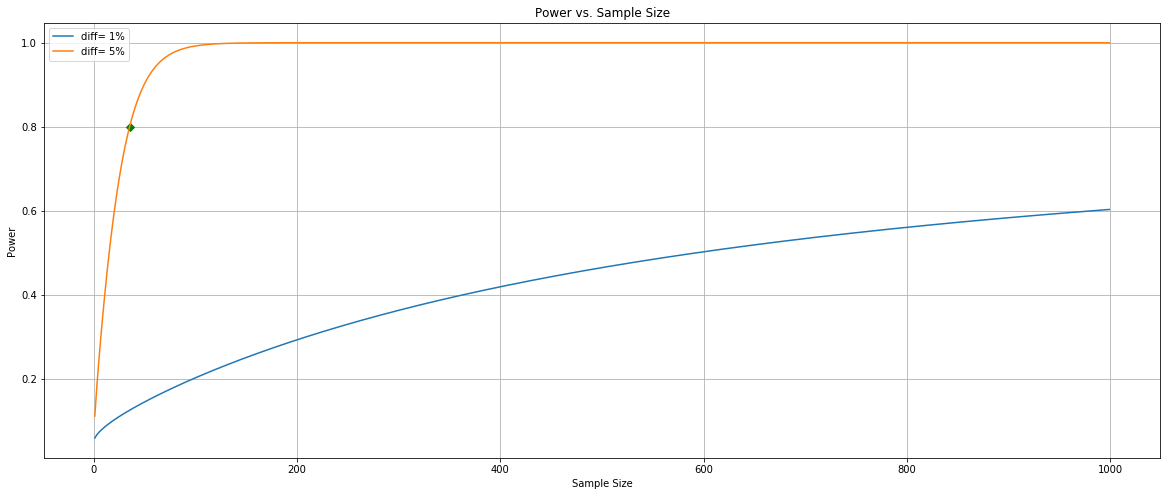

In [69]:
test_ttest_power_diff(df_1.iloc[-6:].mean().iloc[0],
                      df_1.iloc[-6:].std().iloc[0], 
                      sample1_size=1000, 
                      alpha=0.05, 
                      desired_power=0.8, 
                      mean_diff_percentages=[0.01, 0.05], 
                      alternative='larger')

# выделение тестовой группы
##### A: cg_size, B: (1 - cg_size)

In [ ]:
np.random.seed(5)

cg_size = 0.15

# установление интервалов по отобранным фичам
blnc = []
pos = []
inc = []
age = []
gender = df_sb1.gender.unique().tolist()
tb = df_model[~df_model.tb_name.isnull()].tb_name.unique().tolist()

for i in [0, .2, .4, .6, .8, 1]: # [0, .25, .5, .75, 1]
    blnc.append(df_model.tot_amt.quantile(i))
    pos.append(df_model.pos_avg_3m_amt.quantile(i))
    inc.append(df_model.inc_avg_amt.quantile(i))
    age.append(df_model.age.quantile(i))
    
# проход по карманам и выделение A/B групп
df_A = pd.DataFrame(columns=df_model.columns)
df_B = pd.DataFrame(columns=df_model.columns)
df_cur = df_model.copy()

for b_i in tqdm(range(len(blnc)-1)):
    for p_i in range(len(pos)-1):
        for inc_i in range(len(inc)-1):
            for a_i in range(len(age)-1):
                for gnd_i in ['M', 'F']:
                #for tb_i in tb:
                    index = df_cur[   ((blnc[b_i]<=df_cur.tot_amt) & (df_cur.tot_amt<=blnc[b_i+1]) | df_cur.tot_amt.isnull())
                                    & ((pos[p_i]<=df_cur.pos_avg_3m_amt) & (df_cur.pos_avg_3m_amt<=pos[p_i+1]) | df_cur.pos_avg_3m_amt.isnull())
                                    & ((inc[inc_i]<=df_cur.inc_avg_amt) & (df_cur.inc_avg_amt<=inc[inc_i+1]) | df_cur.inc_avg_amt.isnull())
                                    & ((age[a_i]<=df_cur.age) & (df_cur.age<=age[a_i+1]) | df_cur.age.isnull())
                                    & ((df_cur.gender==gnd_i) | df_cur.gender.isnull())
                                    #& ((df_cur.tb_name==tb_i) | df_cur.tb_name.isnull())
                                  ].index
                    
                    ind_new = df_cur.loc[index][~df_cur.epk_id.isin(df_campaign.epk_id.unique())].index
                    a_1 = np.random.choice(ind_new, int(round(len(index)*cg_size,0)), replace=False) #int(len(index)/2)
                    
                    #a_1 = np.random.choice(index, int(round(len(index)*0.15,0)), replace=False) #int(len(index)/2)
                    a_2 = list(set(index) - set(a_1))

                    df_A = pd.concat([df_A, df_cur.loc[a_1]])
                    df_B = pd.concat([df_B, df_cur.loc[a_2]])

                    df_cur = df_cur.loc[set(df_cur.index) - set(index)]
del(df_cur)

In [ ]:
for col in ['tot_amt', 'pos_avg_3m_amt', 'inc_avg_amt', 'age']:
    sns.distplot(df_A[df_A[col] <= df_A[col].quantile(0.99)][col], bins = 20)
    sns.distplot(df_B[df_B[col] <= df_B[col].quantile(0.99)][col], bins = 20)
    plt.show()

# проверка стат-значимости

H0: open_rate в двух группах равны
H1: open_rate в группе без коммуникации выше

Ошибка I рода: отвергнута правильная H0

статистический критерий: отклоняет H0, или не отклоняет H0

H0 - средние в двух группах равны
H1 - среднее в группу "В" выше, чем в группе "А"

статистическая значимость - мера уверенности в том, что результат не является случайным (обычно берется 5% или 1%)
p-value - вероятность получения результатов, по крайней мере, столь же экстремальных, как наблюдаемые результаты проверки статистической гипотезы, при условии, что нулевая гипотеза верка
p-value - вероятность получить тот датасет с данными, который мы получили, если нулевая гипотеза верна

p-value < уровень значимости → разница существует
p-value > уровень значимости → нет оснований для отклонения H0

t-test - проверка равенства средних между группами

конверсия - биномиальная метрика (1,0)

Хи-квадрат

Bootstrap
Если 0 попадает в доверительный интервал, разница незначима.
Bootstrap-распределение разниц средней суммы потреба.

Мощность теста - вероятность правильного отклонения нулевой гипотезы, если она ложна.
Мощность теста - вероятность увидеть различия там, где они действительно есть.

Низкая мощность → будем получать, что разницы нет, хотя она там есть.

Обычно берется 80%+

##### Сравнение доли открытых кредитов
доля является биномиальной метрикой, поэтому использую критерий Хи-квадрат <br>
H0: доли в двух группах равны  <br>
p-value = 3.1458642512892177e-26 (<0.05) → H0 отвергаем, разница в двух группах существует (стат. Значима)
##### Сравнение средней суммы кредитов
использую методологию Bootstrap: <br>
95% доверительный интервал находится левее нулевого значение → обнаружена стат. значимая разница в средней сумме кредита

##### Xи-квадрат

In [45]:
alpha = 0.05

chi2stat, pval, table = proportion.proportions_chisquare(df_2.loc[0:1, 'flg_potreb'], df_2.loc[0:1, 'client_count'] )
print('p-value = ', pval)
print(pval < alpha)

p-value =  3.1458642512892177e-26
True


In [31]:
alpha = 0.05

chi2stat, pval, table = proportion.proportions_chisquare(df_2.loc[2:3, 'flg_potreb'], df_2.loc[2:3, 'client_count'] )
print('p-value = ', pval)
print(pval < alpha)

p-value =  8.132864119028138e-08
True


##### Bootstrap

/opt/cloudera/parcels/PYENV.ZNO0059623792/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


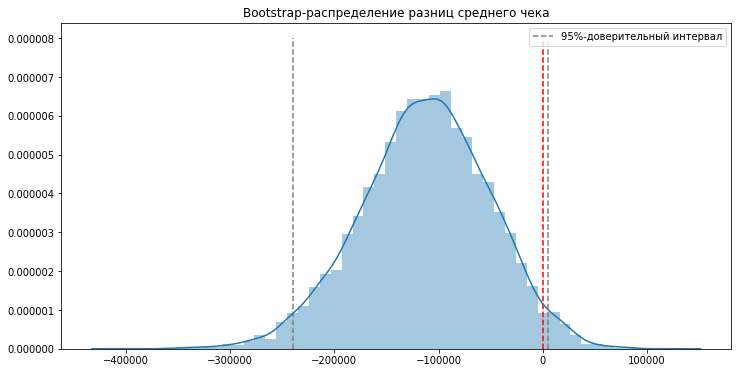

In [81]:
# bootstrap → mean → difference
boot_results = bs.bootstrap_ab(test = df_merged[df_merged.camp_group=='model+sms']['credit_amt'].dropna().values,
                               ctrl = df_merged[df_merged.camp_group=='model']['credit_amt'].dropna().values,
                               stat_func = bs_stats.mean,
                               compare_func = bs_compare.difference,
                               return_distribution=True
                              )

# персентили
borders = np.percentile(boot_results, [2.5, 97.5])

# графическая отрисовка
sns.distplot(boot_results)
plt.title('Bootstrap-распределение разниц среднего чека')
plt.rcParams['figure.figsize'] = (12, 6)
plt.vlines(0, ymin = 0, ymax = 0.000008, linestyles='--', colors='red')
plt.vlines(borders, ymin=0, ymax=0.000008, linestyles='--', colors='grey', label='95%-доверительный интервал')
plt.legend()
plt.show()

##### мощность

мощность теста - <br>
- вероятность правильного отклонения нулеой гипотезы, если она ложна <br>
- вероятность увидеть различия там, где они действительно есть <br>
<br>
обычно берется мощность 80%+

In [84]:
chipower = smp.GofChisquarePower()

def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [85]:
chipower.solve_power(  effect_size = chi2_effect_size(df_2.loc[0, 'potreb_rate'], df_2.loc[1, 'potreb_rate']),
                       nobs = min(df_2.loc[0, 'client_count'], df_2.loc[1, 'client_count']),
                       alpha = pval,
                       power = None
                    )

0.11627460198373296

In [86]:
chipower.solve_power(  effect_size = chi2_effect_size(df_2.loc[0, 'potreb_rate'], df_2.loc[1, 'potreb_rate']),
                       nobs = None,
                       alpha = 0.05,
                       power = 0.8
                    )

263.75753654382396